In [1]:
from tensorflow import keras

## 보스턴 주택 가격 데이터셋

1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해 보겠다.  

데이터 포인트가 506개로 개수가 적고 404개는 훈련 샘플로 102개는 테스트 샘플로 나누어져 있다. 입력 데이터에 있는 각 특성은 스케일이 서로 다르다.

In [2]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [3]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


타깃은 주택의 중간 가격으로 천달러 단위이다.

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 준비

상이한 스케일을 가진 값을 신경망에 주입하면 문제가 된다. 이런 데이터를 다룰 때 대표적인 방법은 특성별로 정규화를 하는 것이다. 입력 데이터에 있는 각 특성에 대해서 특성의 평균을 빼고 표준 편차로 나눈다.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

테스트 데이터를 정규화할 때 사용한 값이 훈련 데이터에서 계산한 값임을 주목하자. 머신 러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안된다.

## 모델 구성

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # 동일한 모델을 여러 번 생상해야 하므로 함수를 만든다.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

## K-fold 검증을 사용한 훈련 검증

데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아진다. 결국 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택됐는지에 따라 검증 점수가 크게 달라진다.  
검증 세트의 분할에 대한 검증 점수의 분산이 높다. 이렇게 되면 신뢰있는 모델 평가를 신뢰있게 할 수 없다.

이런 상황에서 가장 좋은 방법은 K-fold 교차 검증를 사용하는 것이다. 데이터를 K개의 분할로 나누고 K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법이다. 모델의 검증 점수는 K개의 검증 점수의 평균이 된다.

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [12]:
all_scores

[2.1377031803131104, 2.3184854984283447, 2.5573670864105225, 2.457824945449829]

In [13]:
np.mean(all_scores)

2.3678451776504517

검증 세트가 다르므로 확실히 검증 점수의 변화가 크다. 평균값이 훨씬 신뢰할 만한 점수이다. 이것이 k-fold의 핵심이다. 이 예에서는 평균적으로 2300달러정도 차이가 난다. 신경망을 조금 더 오래 훈련해보자. 각 에폭마다 모델이 얼마나 개선되는지 기록하기 위해 훈련 루프를 조금 수정해서 검증 점수를 로그에 저장하겠다.

In [14]:
from tensorflow.keras import backend as K

# 메모리 해제
K.clear_session()

In [15]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


그 다음 모든 폴드에 대해 에폭의 MAE 평균을 계산한다. 

In [18]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

시각화를 해보자

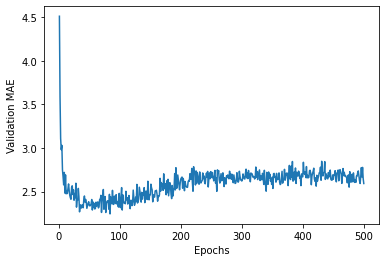

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

이 그래프는 범위가 크고 변동이 심하기 때문에 보기 힘들다. 다음처럼 해보자.
* 곡선의 다른 부분과 스케일이 많이 다른 첫 10개 데이터 포인트를 제외시킨다.
* 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체한다.

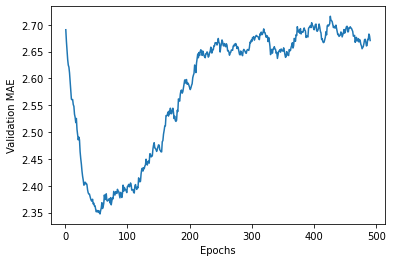

In [21]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


이 그래프를 보면 검증 MAE가 80번쨰 에폭 이후에 줄어드는 것이 멈추었다. 이 지점 이후로는 과대적합이 시작된다.

모델의 다른 매개변수에 대한 튜닝이 끝나면 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킨다. 그다음 테스트 데이터로 성능을 확인한다.

In [22]:
# 새롭게 컴파인된 모델을 얻는다
model = build_model()
# 전체 데이터로 훈련시킨다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 16.5988 - mae: 2.4527


In [23]:
test_mae_score

2.4526565074920654

아직 2,452달러 정도 차이가 난다.